<div style="max-width:1200px"><img src="../_resources/mgnify_banner.png" width="100%"></div>

<img src="../_resources/mgnify_logo.png" width="200px">

# Notebook objective

The aim of this notebook is to demonstrate how to integrate the MGnify APIs and the ESMAtlas API to obtain an integrated view of the proteins that belong to the MGnify Protein DB.

## Steps

1. Fetch the protein PDB structure file, and display it on an interactive viewer.
2. Run a sequence similarity check of the selected protein, and view a Multiple Sequence Alignment (MSA) 
3. Obtain the study, assembly and contigs that contain the selected protein.
4. View the genomic context of the selected protein.

_Disclaimer: the MGnify ProteinDB API is not available at the moment_

The API utilized in this notebook return JSON data. The `requests` package can help you load this data into Python, can help you obtain the information from it.

# ESM Metagenomic Atlas

The [ESM Metagenomic Atlas](https://esmatlas.com) contains over 600 million predicted protein structures, revealing the metagenomic world in a way we have never seen before. The Explore page visualizes a sample of 1 million of these. (That’s about how much a browser can handle.) We represent each protein in this dataset as a single point, and reveal the actual protein structure when zooming in or when hovering over it. The color of each point corresponds to the similarity to the closest match we could find in UniRef90, the reference database of known protein sequences. The position in the map is a two-dimensional projection, which groups sequences by similarity, as determined by our language model’s internal representation. The map reveals structure at different scales: local neighbors in the same cluster tend to have similar structures, while nearby clusters preserve certain patterns like secondary structure elements


**This example shows you how to load a protein from the MGnify Protein DB API and the structure for it from the ESMAtlas API**

This is an interactive code notebook (a Jupyter Notebook).
To run this code, click into each cell and press the ▶ button in the top toolbar, or press `shift+enter`.

Before we start we need to setup the environment.

In [2]:
# We need to import some libraries before we start
import subprocess

import requests
from urllib.request import urlretrieve

import pandas as pd

from IPython.display import JSON

# ESM Altas API endpoints

ESM_BASE = "https://api.esmatlas.com"
ESM_STRUCTURE_API = f"{ESM_BASE}/fetchPredictedStructure"
ESM_PREDICTION_CONF_API = f"{ESM_BASE}/fetchConfidencePrediction"

# MGnify ProteinDB endpoint
MGNIFY_PROTDB_BASE = "http://localhost:8000"

# MGnify API
MGNIFY_API_BASE = "https://www.ebi.ac.uk/metagenomics/api/v1"


# Select a protein (MGYP)
Pick a particular protein of interest, modify the value of `MGYP` as required.

In [3]:
MGYP = "MGYP001170388990"

# Get the protein PDB from the ESM Altlas API

This API endpoint results the PDB file containing the protein structure information for a given ID that starts with MGYP.
This notebook uses the [py3Dmol](https://pypi.org/project/py3Dmol/) library to display an interactive visualization of the protein structure. The code to view the structure can be found here on this link [protein_visualization.py](lib/protein_visualization.py)

In [3]:
# Retrieve the .pdb from the API
urlretrieve(f"{ESM_STRUCTURE_API}/{MGYP}", f"{MGYP}.pdb")

('MGYP001170388990.pdb', <http.client.HTTPMessage at 0x7fb2bbbc0a30>)

### Fetch the predicted structure
The predicted structure is colored by local prediction confidence (pLDDT) per amino acid location. Blue indicates confident predictions (pLDDT > 0.9), while red indicates low confidence (pLDDT < 0.5).

For more information about it, please go follow to the [ESM Altlas docs](https://esmatlas.com/about#explore_the_esm_metagenomic_atlas)

In [4]:
# protein structure
from lib import protein_visualization

view = protein_visualization.view_pdb(
    open(f"{MGYP}.pdb", "r").read(),
    color="pLDDT",
)

view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

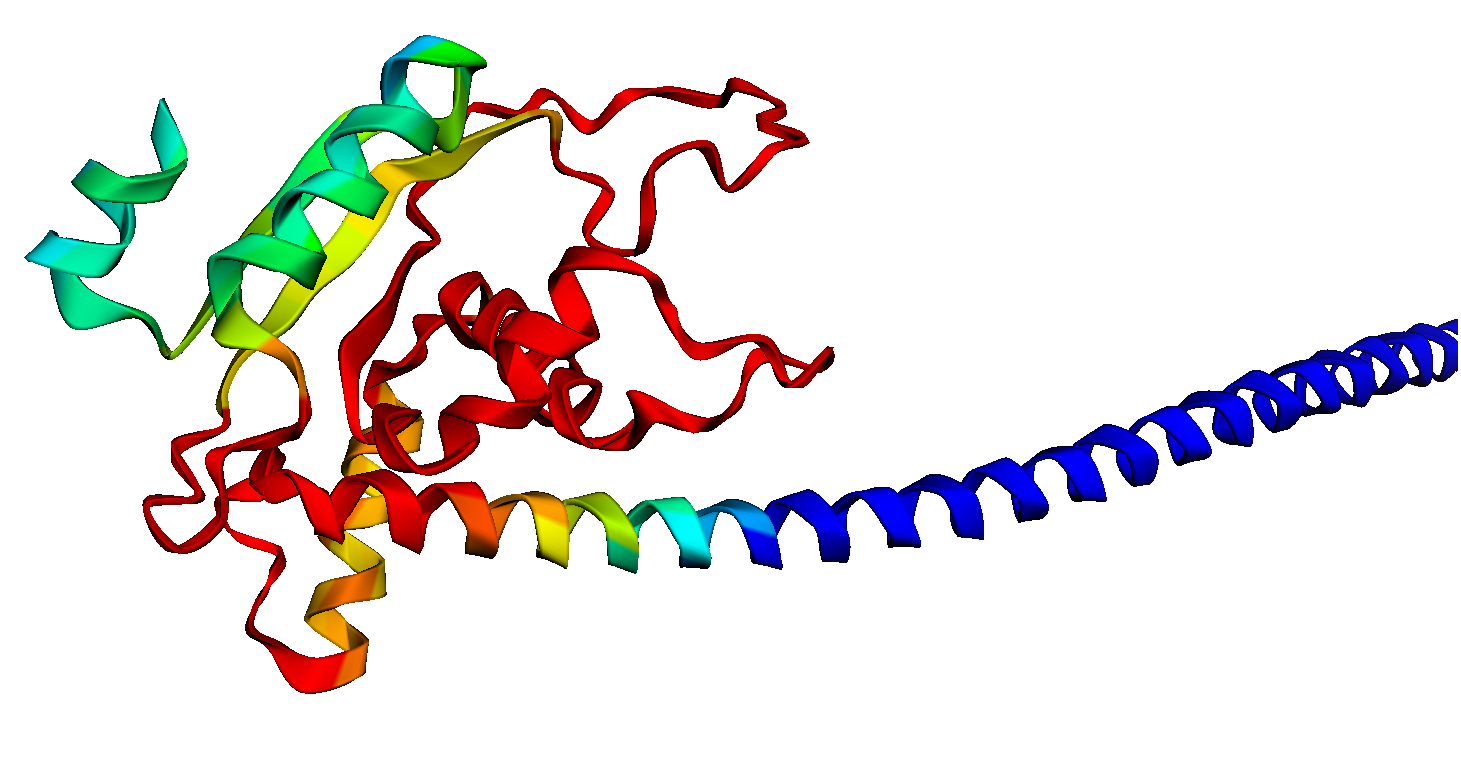

In [13]:
# Let's freeze the model
# Uncomment to get a png of the structure
# view.png()

# Rendering an example
from IPython.display import Image
Image(filename="MGYP001170388990_structure.png")

# Sequence similary search using the MGnify sequence search service API

This service uses the HMMER search engine, which has been adapted to provide fast searches against the MGnify Protein DB. The results can be linked back to the sample and run from which the protein was derived, and also to sequences with an exact match in the UniProtKB database.

Search the selected MGYP against the rest of the MGnify Protein DB using the service API, the results will be loaded into a [Pandas dataframe](https://pandas.pydata.org/docs/user_guide/index.html). 

In [72]:
# mgnify - sequence search wrapper
from mg_toolkit.search import SequenceSearch

# Obtain the aa sequence from the MGnify ProteinDB API
protein_response = requests.get(f"{MGNIFY_PROTDB_BASE}/proteins/{MGYP}")
protein_json = protein_response.json()

# Search using Mgnify Sequence search
search_object = SequenceSearch(
    protein_json["sequence"],
    MGYP,
)
search_response = search_object.analyse_sequence()

search_results_df = None

if not search_response:
    print("No results to report for MGYP")
else:
    # The sequence hits
    hits = search_response.get("results").get("hits")
    # Let's format the results a bit
    search_results_df = pd.json_normalize(hits)
    search_results_df['evalue'] = search_results_df['evalue'].astype(float)
    search_results_df.rename(columns={'name': 'Target Name'}, inplace=True)
    search_results_df = search_results_df[['Target Name', 'evalue']]

search_results_df.sort_values(by="evalue")
search_results_df

,Target Name,evalue
0,MGYP000344949950,1.400000e-64
1,MGYP000268267999,2.600000e-63
2,MGYP000563143566,5.700000e-61
3,MGYP000497979482,2.700000e-55
4,MGYP000722085872,5.900000e-53
...,...,...
310,MGYP000624375544,9.400000e-01
311,MGYP000372990899,9.600000e-01
312,MGYP000203149228,9.600000e-01
313,MGYP000131179329,9.800000e-01


## Select the top 10 hits, based on the evalue. 

In [73]:
top10_hits = search_results_df['Target Name'].head(10).tolist()

top10_hits

['MGYP000344949950',
 'MGYP000268267999',
 'MGYP000563143566',
 'MGYP000497979482',
 'MGYP000722085872',
 'MGYP000575666241',
 'MGYP000119631963',
 'MGYP000005532180',
 'MGYP000055667231',
 'MGYP000400664042']

## Create am MSA

Align the top 10 hits with [muscle](https://github.com/rcedgar/muscle)... and see how the multiple sequence alignment looks like.

The first step if to obtain the protein sequence for all the matches using the MGnify Protein DB API.

To build the FASTA file from the sequences we got from the API we can use [biopython](https://pypi.org/project/biopython/). 

In [74]:
# fasta and alingment helpers 
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO, SeqIO
from Bio.Seq import Seq

sequences = []

# Add the MGYP to the list
sequences.append(SeqRecord(Seq(protein_json["sequence"]), id=MGYP))

for hit_mgyp in top10_hits:
    hit_response = requests.get(f"{MGNIFY_PROTDB_BASE}/proteins/{hit_mgyp}")

    if not hit_response.ok:
        # TODO this shouldn't happen in production
        print(f"{hit_mgyp} missing.")
        continue

    hit_data = hit_response.json()
    hit_sequence = hit_data["sequence"]
    hit_id = hit_data["id"]
    # TODO: pad with MGYP and 0.. on the API
    sequences.append(SeqRecord(Seq(hit_sequence), id=f"MGYP{hit_id}"))

# Align with muscle
SeqIO.write(sequences, f"{MGYP}_tophits.fasta", "fasta")

subprocess.run(["muscle", "-align", f"{MGYP}_tophits.fasta", "-output", f"{MGYP}_tophits.afa"])



muscle 5.1.linux64 []  16.0Gb RAM, 8 cores
Built Feb 24 2022 03:16:15
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 11 seqs, avg length 318, max 693

00:00 7.8Mb  CPU has 8 cores, running 8 threads
00:01 540Mb   100.0% Calc posteriors
00:01 540Mb   100.0% Consistency (1/2)
00:01 540Mb   100.0% Consistency (2/2)
00:01 540Mb   100.0% UPGMA5           
00:01 540Mb   100.0% Refining


CompletedProcess(args=['muscle', '-align', 'MGYP001170388990_tophits.fasta', '-output', 'MGYP001170388990_tophits.afa'], returncode=0)

## View the MSA

In [76]:
from rich.jupyter import print as rich_print
from rich_msa import RichAlignment

msa = AlignIO.read(f"{MGYP}_tophits.afa", "fasta")

viewer = RichAlignment(
    names=[record.id for record in msa],
    sequences=[str(record.seq) for record in msa],
    max_name_width=len(MGYP),
)

rich_print(viewer)

MGYP563143566        1  MSKQ--------------------------VL---------------------------------------------------------- 
MGYP55667231         1  MEAG--------------------------ATPAAAAVECVRNGGTNLLDPLGRGVEQEHPRALAAGEQDGTGVAGAASGVGDAAQEAEV 
MGYP344949950        1  MNAQ--------------------------IK---------------------------------------------------------- 
MGYP497979482        1  MSGT--------------------------SN---------------------------------------------------------- 
MGYP5532180          1  MSRA--------------------------GL---------------------------------------------------------- 
MGYP119631963        1  MCSSDLKPDMDHLRYDSGVSRFLEEFMSNTLS---------------------------------------------------------- 
MGYP722085872        1  MSGN--------------------------SQ---------------------------------------------------------- 
MGYP268267999        1  MAQQ--------------------------WF---------------------------------------------------------- 
MGYP400664042        1  MSEYDDDDDL---SYGGGGTGLVAM-----VL---------------------------------------------------------- 
MGYP001170388990     1  ------------------------------------------------------------------------------------------ 
MGYP575666241        1  MLNDDAPNSAL--RIKK--[1;38;

# Fetch the protein metadata

Using the MGnify Protein DB fetch the useful metadata about the selected protein.

## Biomes where the protein was found

Let's start by looking on which biomes this protein was found

In [77]:
biomes_response = requests.get(f"{MGNIFY_PROTDB_BASE}/proteins/{MGYP}/biomes")
biome_lineages = [biome.get("lineage") for biome in biomes_response.json()]

biomes_df = pd.DataFrame(biome_lineages, columns=["lineage"])

biomes_df.sort_values(by="lineage")

,lineage
9,root:Environmental:Air
3,root:Environmental:Aquatic:Freshwater:Groundwater
5,root:Environmental:Aquatic:Marine
8,root:Environmental:Aquatic:Marine:Oceanic
6,root:Environmental:Terrestrial:Soil:Permafrost
4,root:Host-associated:Human:Digestive system
2,root:Host-associated:Human:Digestive system:La...
0,root:Host-associated:Human:Digestive system:Or...
1,root:Host-associated:Human:Skin
7,root:Host-associated:Plants


## Fetch the studies where the protein was found

In [78]:
studies_response = requests.get(f"{MGNIFY_PROTDB_BASE}/proteins/{MGYP}/studies")

display(f"Fetching the studies for the protein {MGYP}")

studies_df = pd.DataFrame.from_dict(studies_response.json())

studies_df

'Fetching the studies for the protein MGYP001170388990'

,id,accession
0,116,ERP104174


## Fetch the assemblies that contain that protein in any given study

In [79]:
# Pick the first one
study_accession = studies_df['accession'].iloc[0]

display(f"Fetching the assemblies for the study {study_accession}")

assemblies_response = requests.get(f"{MGNIFY_PROTDB_BASE}/proteins/{MGYP}/studies/{study_accession}/assemblies")

assemblies_df = pd.DataFrame.from_dict(assemblies_response.json())

# The reponse will contain the assembly accession and which version of the mgnify pipeline was used for the analysis of said assembly
assemblies_df

'Fetching the assemblies for the study ERP104174'

,id,accession,pipeline_version
0,29457,ERZ842408,5.0


## Fetch the contigs that contain the selected protein

Using the data from the study and assemblies, it's possible to fetch the contigs. 

For this example, we will fetch the first contig, and we will display it on the IGV viewer.

In [80]:
assembly_accession = assemblies_df['accession'].iloc[0]

contigs_response = requests.get(f"{MGNIFY_PROTDB_BASE}/assemblies/{assembly_accession}/contigs?mgyp={MGYP}")

contigs_response_df = pd.DataFrame.from_dict(contigs_response.json())

contigs_response_df

,id,kmer_coverage,length,contig_name
0,1782524379,3,700,ERZ842408.721442-NODE-1579160-length-700-cov-3...


# Genomic context of the protein

Using the information obtained from the MGnify ProteinDB API and the MGnify API, it's possible to explore the genomic context for the protein.

The contig DNA sequence and functional annotations can be obtained from the MGnify API.

The first step if to obtain the MGnify analysis accession for the assembly. Only those analyses for version 5.0 of the MGnify pipeline are considered, as previous versions of the pipeline don't have the contigs indexed.


In [84]:
MGYC_id = contigs_response_df['id'].iloc[0]
# The contig name is required.. MGYC are not indexed in the MGnify at the moment of writing this
MGYC_name = contigs_response_df['contig_name'].iloc[0]

analyses_response = requests.get(f"{MGNIFY_API_BASE}/assemblies/{assembly_accession}/analyses?pipeline_version=5.0")

if not analyses_response.ok:
    print("Something went wrong with the MGnify API")

analyses_data = analyses_response.json()

# We want to keep v5 analyses, previuos versions don't have the contigs indexed in the API

v5_analysis = analyses_data.get("data")[0]
MGYA = v5_analysis.get("id")

display(f"For the assembly {assembly_accession}, the corresponding MGnify analysis is {MGYA}")

urlretrieve(f"https://www.ebi.ac.uk/metagenomics/api/v1/analyses/{MGYA}/contigs/{MGYC_name}", f"{assembly_accession}_contig.fasta")
urlretrieve(f"https://www.ebi.ac.uk/metagenomics/api/v1/analyses/{MGYA}/contigs/{MGYC_name}/annotations", f"{assembly_accession}_contig.gff")


'For the assembly ERZ842408, the corresponding MGnify analysis is MGYA00590527'

('ERZ842408_contig.gff', <http.client.HTTPMessage at 0x7f1c71437940>)

In [85]:
# Position of MGYP in the contig

protein_metadata_response = requests.get(f"{MGNIFY_PROTDB_BASE}/proteins/{MGYP}/metadata?mgyc={MGYC_id}")

protein_metadata = protein_metadata_response.json()[0]

start_position = protein_metadata.get("start_protein")
end_position = protein_metadata.get("end_protein")
strand = protein_metadata.get("strand")

JSON(protein_metadata)


<IPython.core.display.JSON object>

We are going to use the IGV genome viewer.

In [86]:
from igv_jupyterlab import IGV

contig_ref = IGV.create_genome(
    name="Test",
    fasta_url=f"/tree/notebooks-src/notebooks/Python%20Examples/{assembly_accession}_contig.fasta",
    indexed=False
)

track = IGV.create_track(
    name="Functional annotations",
    url=f"/tree/notebooks-src/notebooks/Python%20Examples/{assembly_accession}_contig.gff",
    fmtt="gff3",
    type="annotation",
    indexed=False,
    displayMode="EXPANDED"
)

igv = IGV(genome=contig_ref)

igv.load_track(track)

igv.search_locus(MGYC_name, start_position, end_position)

display(igv)


IGV(id='igv_4914930', initialConfig={'id': 'igv_4914930', 'locus': '', 'reference': {'name': 'Test', 'fastaURL…